# Generate individual and compound feature importance bar plots (Dataset 2)
- This notebook is set up to first generate feature importance box plots for each individual ML algorithm
- Next, compound feature importance bar plots were generated to summarize feature importance results across all ML algorithms
- Four versions of this compound feature importance bar plot were generated each processing the data differently:
    - Normalization of each ML algorithms scores within range (0-1)
    - Normalization + Fraction adjustment (i.e. each algorithm has a maximum overall bar area across figure)
    - Normalization + Algorithm performance weighting (i.e. feature importance scores are downweighted based on poor algorithm performance
    - Normalization + Fraction correction + Algorithm performance weighting

## Import Necessary Packages & Read in Data

In [1]:
#Basic Packages
import os
import random
import copy
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None) # display all the columns
import scipy.stats as scs
from scipy.stats import randint
import warnings
warnings.filterwarnings('ignore')

#Visualization Packages:
%matplotlib inline   
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.tree import _tree
from matplotlib import pyplot
import graphviz 
from functools import reduce
import pydotplus
from IPython.display import Image
from matplotlib import rc

# Jupyter Notebook Hack: This code ensures that the results of multiple commands within a given cell are all displayed, rather than just the last. 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#Set a random seed for the notebook so that individual runs of the notebook yield the same results
randSeed = 42 #changing this value will potentially change the models and results due to stochastic elements of the pipeline. 
np.random.seed(randSeed)

## Specify dataset specific paths/names

In [2]:
#unique dataset name (target data for this analysis)
data_name = 'Epi_DietAdj_20180710_Clean' 

#algorithm names as specified in the respective analysis pipeline notebooks
algorithms = ['logistic_regression','decision_tree','random_forest','xgboost','naive_bayes','svm','ann','lcs']
algorithms2 = ['logistic_regression','decision_tree','random_forest','xgboost','naive_bayes','svm','ann','lcs','multisurf']
methodsKey = ('Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost','Naïve Bayes', 
              'Support-Vector Machine', 'Neural Networks', 'Learning Classifier System')

results_path = 'C:/home/work/research_collab/Lynch_Bias_ML_Pancreatic/Final Materials/results/notebook_output/'

#import separate LCS analysis results
lcs_results_path = 'C:/home/work/research_collab/Lynch_Bias_ML_Pancreatic/Final Materials/results/summary_files/Whole_Datasets_200000/'
lcs_stats = 'ExSTraCS_2.0.2.1_Epi_DietAdj_20180710_Clean_InstLab_200000_metric_summary.txt'
lcs_fi = 'ExSTraCS_2.0.2.1_Epi_DietAdj_20180710_Clean_InstLab_200000_importance_summary.txt'

metrics = ['Accuracy','Balanced Accuracy','F1_Score','Precision','Recall','Specificity','TN','TP','FN','FP']

multisurf_results_file = 'C:/home/work/research_collab/Lynch_Bias_ML_Pancreatic/Final Materials/results/summary_files/MultiSURF_Epi_DietAdj_20180710_Clean_results_summary.txt'

cv_type = 'CV_S'
multisurf_name = 'MultiSURF_'+data_name+'_'+cv_type+'_'

cv = 10

#Feature names to use in the final publication figures
printfeatureNames = ['cig_stat', 'cig_stop', 'cig_years',
                'pack_years', 'alc use', 'fat_intake', 'calories',
                'carb_intake', 'protein_intake', 'folate_intake',
                'GlyIndex', 'GlyLoad', 'chol_intake', 'redmeat_intake',
                'calcium_intake', 'bmi_curc', 'BMI', 'Diabetes', 'PC Fam Hx',
                'Fam Hx ', 'bmi_20', 'bmi_50', 'Aspirin Use', 'asp dos', 'Ibuprofen Use', 'ibu dose',
                'GallBlad', 'Liver', 'age', 'agelevel', 'edu', 'Race',
                'Marital Status', 'employ', 'center', 'rndyear', 'Sex']

# Load feature importance results and balanced accuracy results
- This is done for all algorithms
- We also load MultiSURF results to view and compare those feature scores as well.

In [3]:
#Logistic Regression
LR_df = pd.read_csv(results_path+data_name+'_'+algorithms[0]+'_FI.csv')
featureNames = LR_df.columns.tolist() #Save list of feature names (from one of the feature importance files - doesn't matter which)
LR_ave = LR_df.mean().tolist()
LR_df_tmp = pd.read_csv(results_path+data_name+'_'+algorithms[0]+'_metrics.csv')
LR_bacc = LR_df_tmp['Balanced Accuracy'].mean()

#Decision Tree
DT_df = pd.read_csv(results_path+data_name+'_'+algorithms[1]+'_FI.csv')
DT_ave = DT_df.mean().tolist()
DT_df_tmp = pd.read_csv(results_path+data_name+'_'+algorithms[1]+'_metrics.csv')
DT_bacc = DT_df_tmp['Balanced Accuracy'].mean()

#Random Forest
RF_df = pd.read_csv(results_path+data_name+'_'+algorithms[2]+'_FI.csv')
RF_ave = RF_df.mean().tolist()
RF_df_tmp = pd.read_csv(results_path+data_name+'_'+algorithms[2]+'_metrics.csv')
RF_bacc = RF_df_tmp['Balanced Accuracy'].mean()

#XGBoost
XG_df = pd.read_csv(results_path+data_name+'_'+algorithms[3]+'_FI.csv')
XG_ave = XG_df.mean().tolist()
XG_df_tmp = pd.read_csv(results_path+data_name+'_'+algorithms[3]+'_metrics.csv')
XG_bacc = XG_df_tmp['Balanced Accuracy'].mean()

#Naive Bayes
NB_df = pd.read_csv(results_path+data_name+'_'+algorithms[4]+'_FI.csv')
NB_ave = NB_df.mean().tolist()
NB_df_tmp = pd.read_csv(results_path+data_name+'_'+algorithms[4]+'_metrics.csv')
NB_bacc = NB_df_tmp['Balanced Accuracy'].mean()

#Support Vector Machine
SV_df = pd.read_csv(results_path+data_name+'_'+algorithms[5]+'_FI.csv')
SV_ave = SV_df.mean().tolist()
SV_df_tmp = pd.read_csv(results_path+data_name+'_'+algorithms[5]+'_metrics.csv')
SV_bacc = SV_df_tmp['Balanced Accuracy'].mean()

#Artificial Neural Networks
NN_df = pd.read_csv(results_path+data_name+'_'+algorithms[6]+'_FI.csv')
NN_ave = NN_df.mean().tolist()
NN_df_tmp = pd.read_csv(results_path+data_name+'_'+algorithms[6]+'_metrics.csv')
NN_bacc = NN_df_tmp['Balanced Accuracy'].mean()

#Learning Classifier Systems - special handling of differently formatted file. 
LC_df = pd.read_csv(lcs_results_path+lcs_fi, sep = "\t")
LC_df = LC_df.transpose()
LC_df = LC_df.drop(LC_df.index[-1]) #drop row with pre-calculated averages
lcs_features = LC_df.iloc[0].tolist()
LC_df = LC_df.drop(LC_df.index[0]) #drop row with pre-calculated averages
LC_df.columns = lcs_features
LC_df = LC_df[featureNames] #put features back into order consistent with original dataset.
LC_ave = LC_df.mean().tolist()
LC_df = LC_df.astype(float)

LC_df_tmp = pd.read_csv(lcs_results_path+lcs_stats, sep = "\t")
LC_df_tmp = LC_df_tmp.drop(LC_df_tmp.index[-1]) #drop row with pre-calculated averages
LC_bacc = LC_df_tmp['BalancedAccuracy'].mean()

#MultiSURF - only feature importances retrieved (no model, so no evaluation metrics for MultiSURF)
MS_df = pd.read_csv(multisurf_results_file, sep = "\t")
MS_df = MS_df.transpose()
MS_df = MS_df.drop(MS_df.index[-1]) #drop row with pre-calculated averages
ms_features = MS_df.iloc[0].tolist()
MS_df = MS_df.drop(MS_df.index[0]) #drop row with pre-calculated averages
MS_df.columns = ms_features
MS_df = MS_df[featureNames] #put features back into order consistent with original dataset.
MS_ave = MS_df.mean().tolist()
MS_df = MS_df.astype(float)

In [4]:
type(featureNames)
for i in featureNames:
    print(i)
NN_df.info()
LC_df.info()
MS_df.info()

MS_df = MS_df.astype(float)
MS_df.info()

list

cig_stat
cig_stop
cig_years
pack_years
total_alcadj
total_fatadj
tot_Kcal
totalcarbadj
total_proteinadj
totalfolate_NDSRadj
total_GlyIndex
total_GlyLoad
totalcholadj
Totalredmeatadj
totalCALCIUMadj
bmi_curc
bmi_curr
diabetes_f
panc_fh
fh_cancer
bmi_20
bmi_50
asp
asppd
ibup
ibuppd
gallblad_f
liver_comorbidity
age
agelevel
educat
race7
total_Marital
occupat
center
rndyear
sex
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 37 columns):
cig_stat               10 non-null float64
cig_stop               10 non-null float64
cig_years              10 non-null float64
pack_years             10 non-null float64
total_alcadj           10 non-null float64
total_fatadj           10 non-null float64
tot_Kcal               10 non-null float64
totalcarbadj           10 non-null float64
total_proteinadj       10 non-null float64
totalfolate_NDSRadj    10 non-null float64
total_GlyIndex         10 non-null float64
total_GlyLoad          10 non-null float64
total

## Generate individual feature importance boxplots for each algorithm

Text(0.5, 1.0, 'logistic_regression')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x272d930deb8>,
 <a list of 37 Text xticklabel objects>)

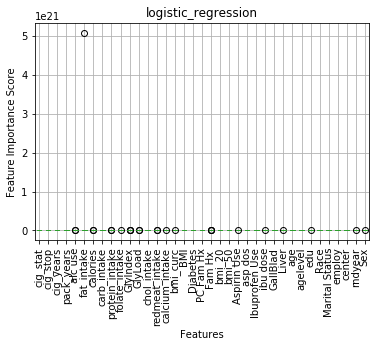

Text(0.5, 1.0, 'decision_tree')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x272d9686400>,
 <a list of 37 Text xticklabel objects>)

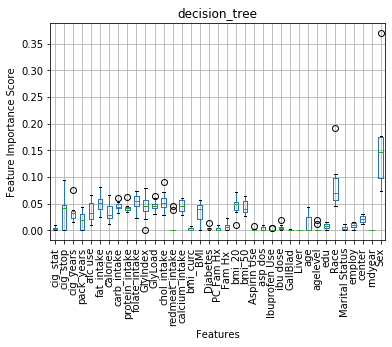

Text(0.5, 1.0, 'random_forest')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x272d9aab208>,
 <a list of 37 Text xticklabel objects>)

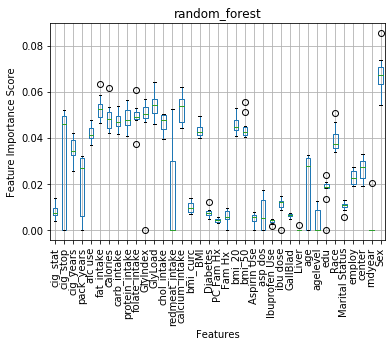

Text(0.5, 1.0, 'xgboost')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x272d9dc77b8>,
 <a list of 37 Text xticklabel objects>)

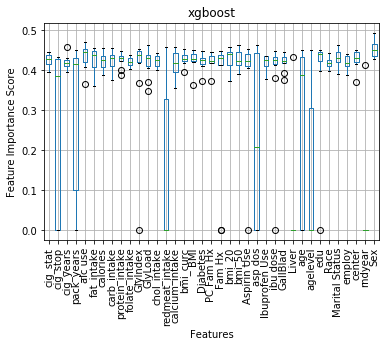

Text(0.5, 1.0, 'naive_bayes')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x272d9a79198>,
 <a list of 37 Text xticklabel objects>)

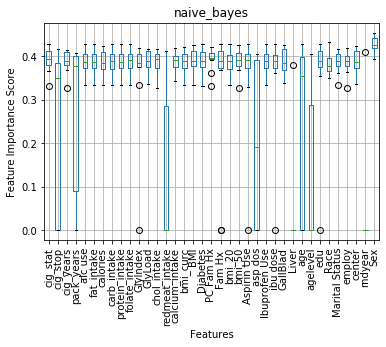

Text(0.5, 1.0, 'svm')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x272d94f0d30>,
 <a list of 37 Text xticklabel objects>)

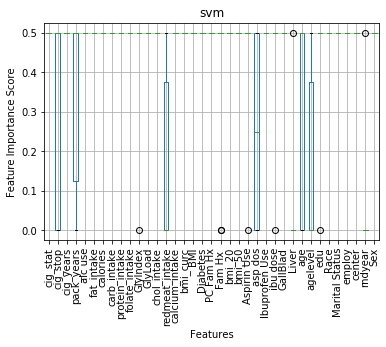

Text(0.5, 1.0, 'ann')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x272da23a8d0>,
 <a list of 37 Text xticklabel objects>)

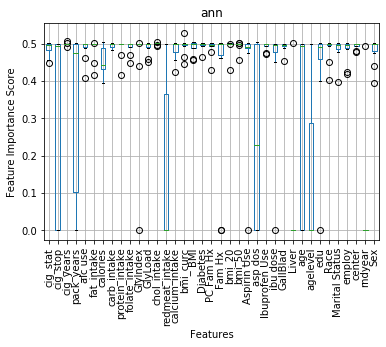

Text(0.5, 1.0, 'lcs')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x272d9498780>,
 <a list of 37 Text xticklabel objects>)

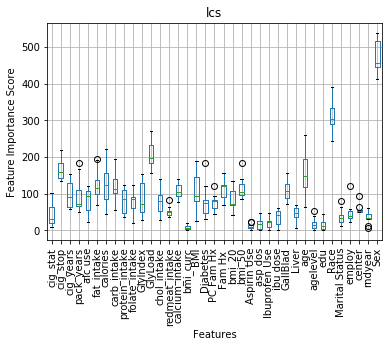

Text(0.5, 1.0, 'multisurf')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x272d9434dd8>,
 <a list of 37 Text xticklabel objects>)

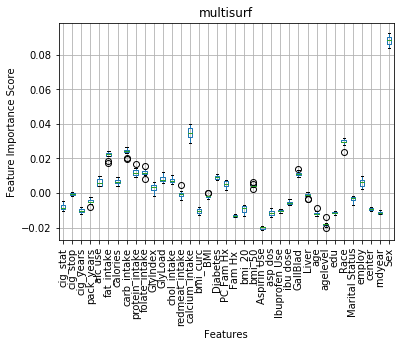

In [5]:
FIList = [LR_df, DT_df, RF_df, XG_df, NB_df, SV_df, NN_df, LC_df, MS_df]

counter = 0
for df in FIList:
    boxplot = df.boxplot(rot=90)
    plt.title(algorithms2[counter])
    plt.ylabel('Feature Importance Score')
    plt.xlabel('Features')
    plt.xticks(np.arange(1,len(printfeatureNames)+1), printfeatureNames,rotation='vertical')
    plt.savefig((results_path+'images/'+'boxplot_' + data_name+'_'+algorithms2[counter]), bbox_inches = "tight")
    plt.show()

    counter += 1

## Normalize Feature Importance Averages
- normalization does the following:
    - highest score in set a value of 1
    - any value at or below zero gets a value of 0
    - positive values scaled between 0 and 1

In [6]:
FIList = [LR_ave, DT_ave, RF_ave, XG_ave, NB_ave, SV_ave, NN_ave, LC_ave]
normLists = []
for each in FIList:
    normList = []
    for i in range(len(each)):
        if each[i] <= 0:
            normList.append(0)
        else:
            normList.append((each[i])/(max(each)))
    normLists.append(normList)

## Compound Feature Importance Plot (Normalized only)

<Figure size 1800x720 with 0 Axes>

([<matplotlib.axis.XTick at 0x272d936c7f0>,
 <a list of 37 Text xticklabel objects>)

([<matplotlib.axis.YTick at 0x272d95fe668>,
 <a list of 10 Text yticklabel objects>)

Text(0.5, 0, 'Feature')

Text(0, 0.5, 'Normalized Feature Importance')

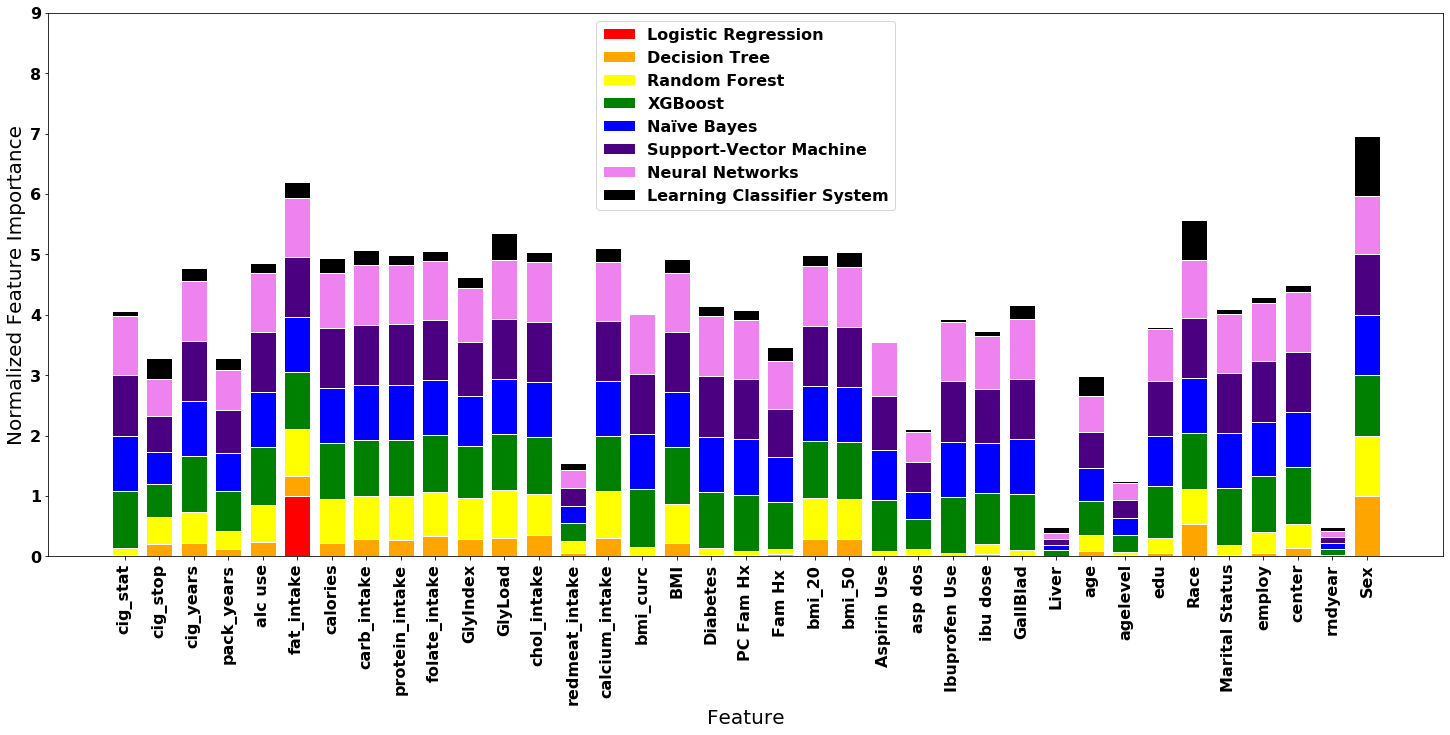

In [7]:
# y-axis in bold
rc('font', weight='bold', size=16)

bottom3 = [sum(i) for i in zip(normLists[0], normLists[1])]
bottom4 = [sum(i) for i in zip(normLists[0], normLists[1], normLists[2])]
bottom5 = [sum(i) for i in zip(normLists[0], normLists[1], normLists[2], normLists[3])]
bottom6 = [sum(i) for i in zip(normLists[0], normLists[1], normLists[2], normLists[3], normLists[4])] 
bottom7 = [sum(i) for i in zip(normLists[0], normLists[1], normLists[2], normLists[3], normLists[4], normLists[5])]
bottom8 = [sum(i) for i in zip(normLists[0], normLists[1], normLists[2], normLists[3], normLists[4], normLists[5], normLists[6])]
    
# The position of the bars on the x-axis
r = featureNames
barWidth = 0.75
plt.figure(figsize=(25,10))

p1 = plt.bar(r, normLists[0], color='red', edgecolor='white', width=barWidth)
p2 = plt.bar(r, normLists[1], bottom=normLists[0], color='orange', edgecolor='white', width=barWidth)
p3 = plt.bar(r, normLists[2], bottom=bottom3, color='yellow', edgecolor='white', width=barWidth)
p4 = plt.bar(r, normLists[3], bottom=bottom4, color='green', edgecolor='white', width=barWidth)
p5 = plt.bar(r, normLists[4], bottom=bottom5, color='blue', edgecolor='white', width=barWidth)
p6 = plt.bar(r, normLists[5], bottom=bottom6, color='indigo', edgecolor='white', width=barWidth)
p7 = plt.bar(r, normLists[6], bottom=bottom7, color='violet', edgecolor='white', width=barWidth)
p8 = plt.bar(r, normLists[7], bottom=bottom8, color='black', edgecolor='white', width=barWidth)

# Custom X axis
plt.xticks(np.arange(len(printfeatureNames)), printfeatureNames,rotation='vertical')
plt.yticks(np.arange(0, 10, step=1))
plt.xlabel("Feature", fontsize=20)
plt.ylabel("Normalized Feature Importance", fontsize=20)

plt.legend( (p1[0],p2[0],p3[0],p4[0],p5[0],p6[0],p7[0],p8[0]), methodsKey, loc=0,fontsize=16)
plt.savefig(results_path+'images/'+data_name+'_'+'Norm_FeatureImp')
# Show graphic
plt.show()

##  Fraction Adjustment of Normalized Feature importances

In [8]:
fracLists = []

for each in normLists:
    fracList = []
    for i in range(len(each)):
        fracList.append((each[i]/(sum(each))))
    fracLists.append(fracList)

## Compound Feature Importance Plot (Normalized + Fraction Adjustment)

<Figure size 1800x720 with 0 Axes>

([<matplotlib.axis.XTick at 0x272d93b6860>,
 <a list of 37 Text xticklabel objects>)

([<matplotlib.axis.YTick at 0x272d97c3198>],
 <a list of 1 Text yticklabel objects>)

Text(0.5, 0, 'Feature')

Text(0, 0.5, 'Normalized Fraction Feature Importance')

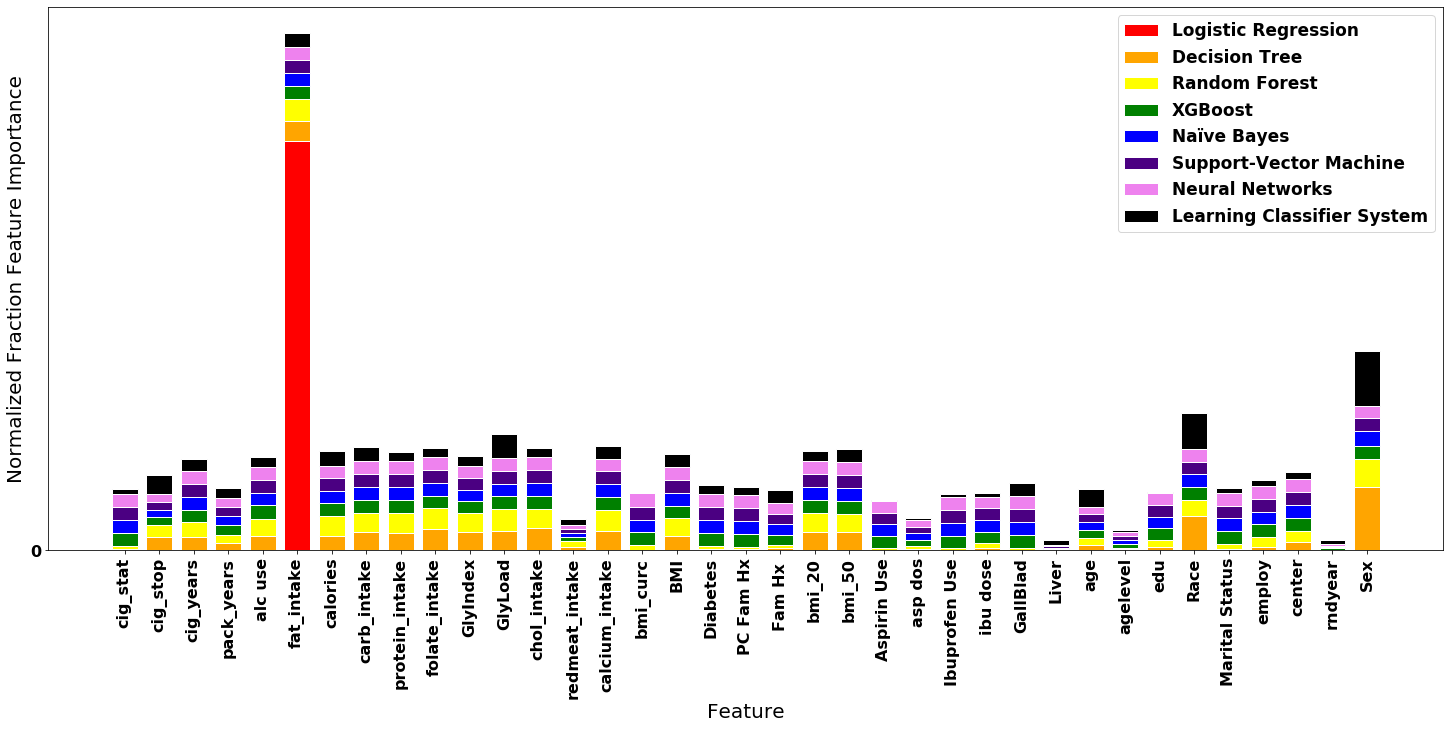

In [9]:
# y-axis in bold
rc('font', weight='bold', size=16)

bottom3 = [sum(i) for i in zip(fracLists[0], fracLists[1])]
bottom4 = [sum(i) for i in zip(fracLists[0], fracLists[1], fracLists[2])]
bottom5 = [sum(i) for i in zip(fracLists[0], fracLists[1], fracLists[2], fracLists[3])]
bottom6 = [sum(i) for i in zip(fracLists[0], fracLists[1], fracLists[2], fracLists[3], fracLists[4])] 
bottom7 = [sum(i) for i in zip(fracLists[0], fracLists[1], fracLists[2], fracLists[3], fracLists[4], fracLists[5])]
bottom8 = [sum(i) for i in zip(fracLists[0], fracLists[1], fracLists[2], fracLists[3], fracLists[4], fracLists[5], fracLists[6])]
    
# The position of the bars on the x-axis
r = featureNames
barWidth = 0.75
plt.figure(figsize=(25,10))

p1 = plt.bar(r, fracLists[0], color='red', edgecolor='white', width=barWidth)
p2 = plt.bar(r, fracLists[1], bottom=fracLists[0], color='orange', edgecolor='white', width=barWidth)
p3 = plt.bar(r, fracLists[2], bottom=bottom3, color='yellow', edgecolor='white', width=barWidth)
p4 = plt.bar(r, fracLists[3], bottom=bottom4, color='green', edgecolor='white', width=barWidth)
p5 = plt.bar(r, fracLists[4], bottom=bottom5, color='blue', edgecolor='white', width=barWidth)
p6 = plt.bar(r, fracLists[5], bottom=bottom6, color='indigo', edgecolor='white', width=barWidth)
p7 = plt.bar(r, fracLists[6], bottom=bottom7, color='violet', edgecolor='white', width=barWidth)
p8 = plt.bar(r, fracLists[7], bottom=bottom8, color='black', edgecolor='white', width=barWidth)

# Custom X axis
plt.xticks(np.arange(len(printfeatureNames)), printfeatureNames,rotation='vertical')
plt.yticks(np.arange(0, 1, step=1))
plt.xlabel("Feature", fontsize=20)
plt.ylabel("Normalized Fraction Feature Importance", fontsize=20)

plt.legend( (p1[0],p2[0],p3[0],p4[0],p5[0],p6[0],p7[0],p8[0]), methodsKey, loc=0,fontsize=17)
plt.savefig(results_path+'images/'+data_name+'_'+'Norm_Frac_FeatureImp')
# Show graphic
plt.show()



##  Performance Weighting of Normalized Feature importances

In [10]:
#Prepare weights
weights = []
bAccList = [LR_bacc, DT_bacc, RF_bacc, XG_bacc, NB_bacc, SV_bacc, NN_bacc, LC_bacc]

# replace all balanced accuraces <=.5 with 0
for i in range(len(bAccList)):
    if bAccList[i] <= .5:
        bAccList[i] = 0

# normalize balanced accuracies
for i in range(len(bAccList)):
    if bAccList[i] == 0:
        weights.append(0)
    else:
        weights.append((bAccList[i]-0.5)/0.5)
        
        
# Weight normalized feature importances
weightedLists = []

for i in range(len(normLists)):
    weightList = np.multiply(weights[i],normLists[i]).tolist()
    weightedLists.append(weightList)

## Compound Feature Importance Plot (Normalized + Perf. Weight Adjustment)

<Figure size 1800x720 with 0 Axes>

([<matplotlib.axis.XTick at 0x272d9e65160>,
 <a list of 37 Text xticklabel objects>)

([<matplotlib.axis.YTick at 0x272d97c2cc0>],
 <a list of 1 Text yticklabel objects>)

Text(0.5, 0, 'Feature')

Text(0, 0.5, 'Normalized Fraction Feature Importance')

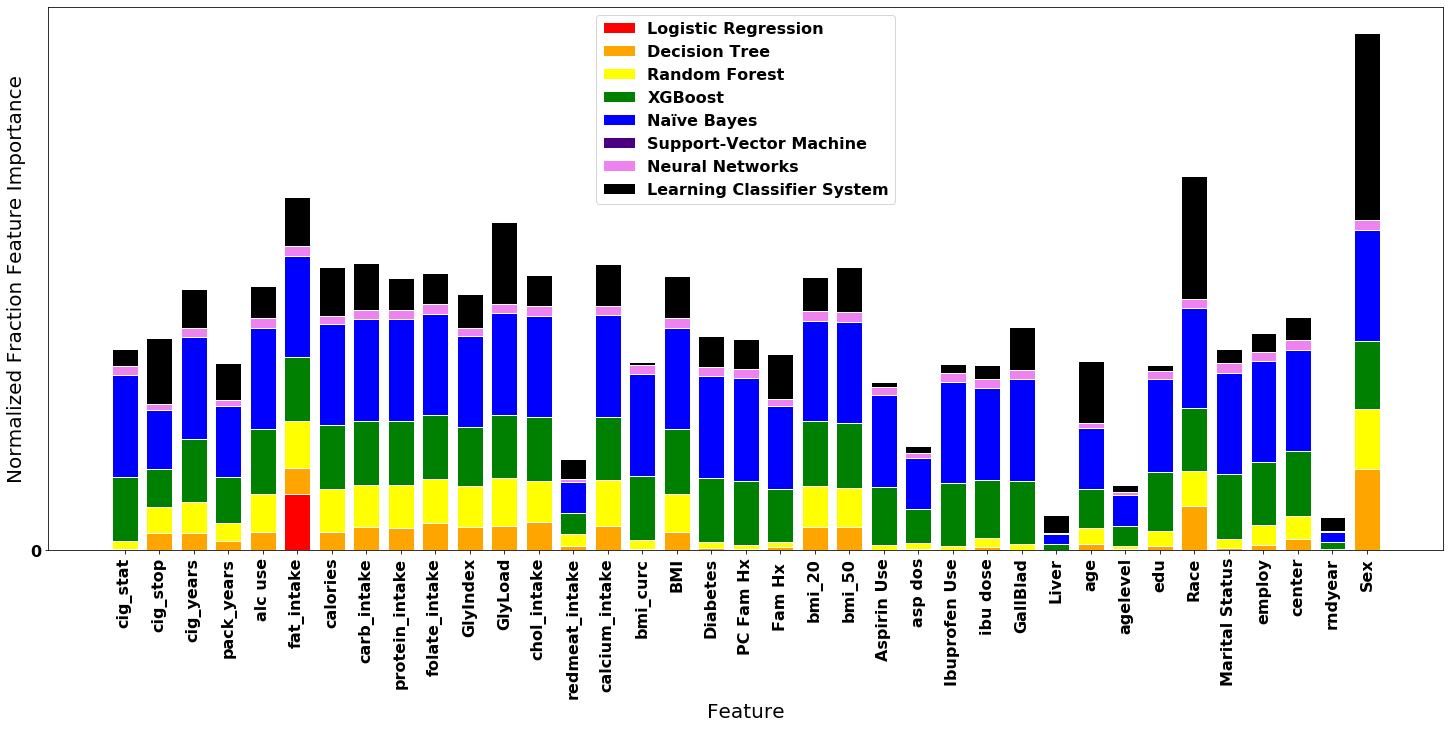

In [11]:
# y-axis in bold
rc('font', weight='bold', size=16)

bottom3 = [sum(i) for i in zip(weightedLists[0], weightedLists[1])]
bottom4 = [sum(i) for i in zip(weightedLists[0], weightedLists[1], weightedLists[2])]
bottom5 = [sum(i) for i in zip(weightedLists[0], weightedLists[1], weightedLists[2], weightedLists[3])]
bottom6 = [sum(i) for i in zip(weightedLists[0], weightedLists[1], weightedLists[2], weightedLists[3], weightedLists[4])] 
bottom7 = [sum(i) for i in zip(weightedLists[0], weightedLists[1], weightedLists[2], weightedLists[3], weightedLists[4], weightedLists[5])]
bottom8 = [sum(i) for i in zip(weightedLists[0], weightedLists[1], weightedLists[2], weightedLists[3], weightedLists[4], weightedLists[5], weightedLists[6])]
    
# The position of the bars on the x-axis
r = featureNames
barWidth = 0.75
plt.figure(figsize=(25,10))

p1 = plt.bar(r, weightedLists[0], color='red', edgecolor='white', width=barWidth)
p2 = plt.bar(r, weightedLists[1], bottom=weightedLists[0], color='orange', edgecolor='white', width=barWidth)
p3 = plt.bar(r, weightedLists[2], bottom=bottom3, color='yellow', edgecolor='white', width=barWidth)
p4 = plt.bar(r, weightedLists[3], bottom=bottom4, color='green', edgecolor='white', width=barWidth)
p5 = plt.bar(r, weightedLists[4], bottom=bottom5, color='blue', edgecolor='white', width=barWidth)
p6 = plt.bar(r, weightedLists[5], bottom=bottom6, color='indigo', edgecolor='white', width=barWidth)
p7 = plt.bar(r, weightedLists[6], bottom=bottom7, color='violet', edgecolor='white', width=barWidth)
p8 = plt.bar(r, weightedLists[7], bottom=bottom8, color='black', edgecolor='white', width=barWidth)

# Custom X axis
plt.xticks(np.arange(len(printfeatureNames)), printfeatureNames,rotation='vertical')
plt.yticks(np.arange(0, 1, step=1))
plt.xlabel("Feature", fontsize=20)
plt.ylabel("Normalized Fraction Feature Importance", fontsize=20)

plt.legend( (p1[0],p2[0],p3[0],p4[0],p5[0],p6[0],p7[0],p8[0]), methodsKey, loc=0,fontsize=16)
plt.savefig(results_path+'images/'+data_name+'_'+'Norm_Weight_FeatureImp')
# Show graphic
plt.show()

##  Performance Weighting of Fract. Adj. and Normalized Feature importances

In [12]:
# Weight normalized feature importances
weightedLists = []

for i in range(len(fracLists)):
    weightList = np.multiply(weights[i],fracLists[i]).tolist()
    weightedLists.append(weightList)

## Compound Feature Importance Plot (Normalized + Frac. + Perf. Weight Adjustment)

<Figure size 1800x720 with 0 Axes>

([<matplotlib.axis.XTick at 0x272d9f5f198>,
 <a list of 37 Text xticklabel objects>)

([<matplotlib.axis.YTick at 0x272da01a710>],
 <a list of 1 Text yticklabel objects>)

Text(0.5, 0, 'Feature')

Text(0, 0.5, 'Norm. Weighted Fraction Feature Importance')

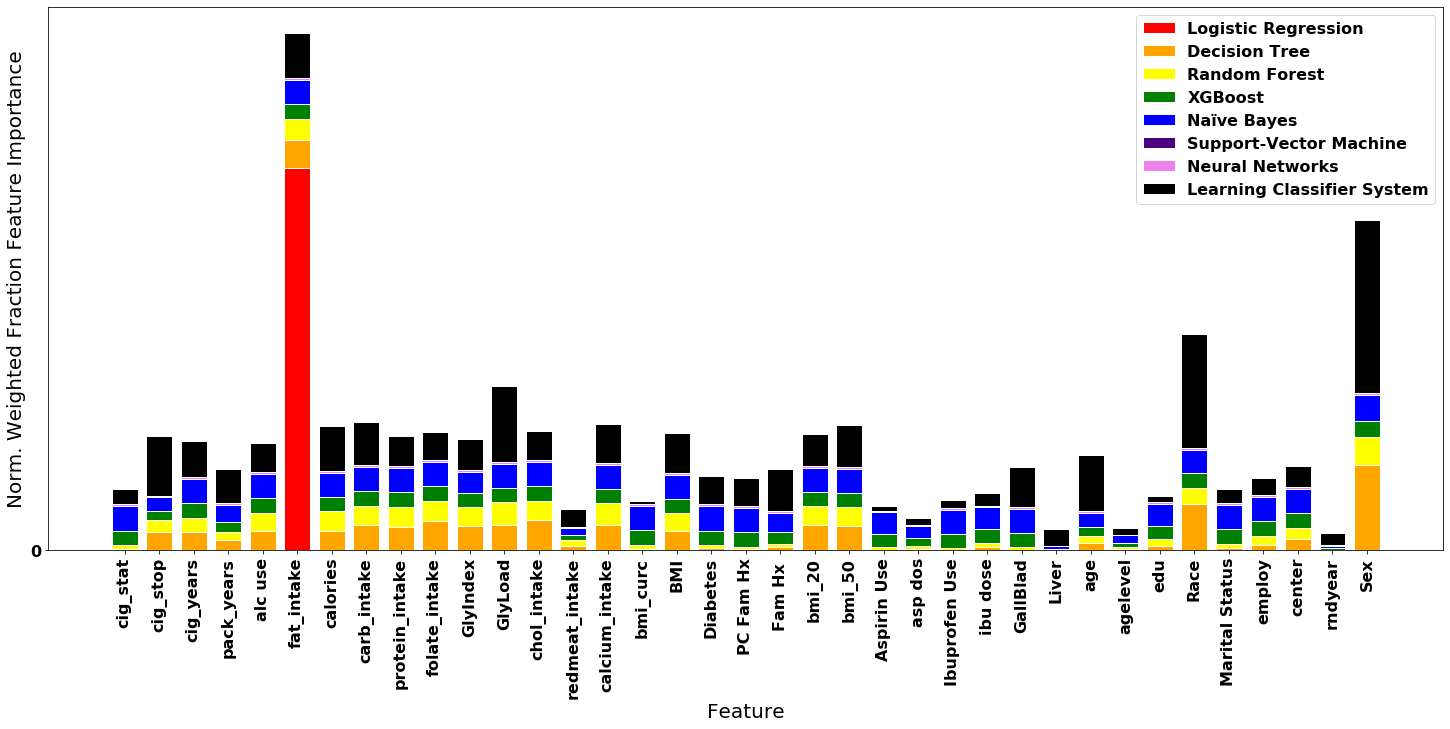

In [13]:
# y-axis in bold
rc('font', weight='bold', size=16)

bottom3 = [sum(i) for i in zip(weightedLists[0], weightedLists[1])]
bottom4 = [sum(i) for i in zip(weightedLists[0], weightedLists[1], weightedLists[2])]
bottom5 = [sum(i) for i in zip(weightedLists[0], weightedLists[1], weightedLists[2], weightedLists[3])]
bottom6 = [sum(i) for i in zip(weightedLists[0], weightedLists[1], weightedLists[2], weightedLists[3], weightedLists[4])] 
bottom7 = [sum(i) for i in zip(weightedLists[0], weightedLists[1], weightedLists[2], weightedLists[3], weightedLists[4], weightedLists[5])]
bottom8 = [sum(i) for i in zip(weightedLists[0], weightedLists[1], weightedLists[2], weightedLists[3], weightedLists[4], weightedLists[5], weightedLists[6])]
    
# The position of the bars on the x-axis
r = featureNames
barWidth = 0.75
plt.figure(figsize=(25,10))

p1 = plt.bar(r, weightedLists[0], color='red', edgecolor='white', width=barWidth)
p2 = plt.bar(r, weightedLists[1], bottom=weightedLists[0], color='orange', edgecolor='white', width=barWidth)
p3 = plt.bar(r, weightedLists[2], bottom=bottom3, color='yellow', edgecolor='white', width=barWidth)
p4 = plt.bar(r, weightedLists[3], bottom=bottom4, color='green', edgecolor='white', width=barWidth)
p5 = plt.bar(r, weightedLists[4], bottom=bottom5, color='blue', edgecolor='white', width=barWidth)
p6 = plt.bar(r, weightedLists[5], bottom=bottom6, color='indigo', edgecolor='white', width=barWidth)
p7 = plt.bar(r, weightedLists[6], bottom=bottom7, color='violet', edgecolor='white', width=barWidth)
p8 = plt.bar(r, weightedLists[7], bottom=bottom8, color='black', edgecolor='white', width=barWidth)

# Custom X axis
plt.xticks(np.arange(len(printfeatureNames)), printfeatureNames,rotation='vertical')
plt.yticks(np.arange(0, 1, step=1))
plt.xlabel("Feature", fontsize=20)
plt.ylabel("Norm. Weighted Fraction Feature Importance", fontsize=20)

plt.legend( (p1[0],p2[0],p3[0],p4[0],p5[0],p6[0],p7[0],p8[0]), methodsKey, loc=0,fontsize=16)
plt.savefig(results_path+'images/'+data_name+'_'+'Norm_Weight_Frac_FeatureImp')
# Show graphic
plt.show()